### Topographic Simulation 

In [11]:
# load library 
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt

from typing import Dict, Any
import networkx as nx

In [12]:
def connect_prob(n_fsn: int = 18, n_msn_d1: int = 51) -> Dict[str, Any]:

    fsn_groups = np.array_split(np.arange(n_fsn), 3)
    msn_d1_groups = np.array_split(np.arange(n_msn_d1), 3)

    # prob
    connection_probabilities = np.array([
        [0.9, 0.5, 0.3], 
        [0.3, 0.9, 0.3], 
        [0.3, 0.5, 0.9],  
    ])
    
    fsn_msn_d1_matrix = np.zeros((n_fsn, n_msn_d1))
    fsn_msn_d1_prob_matrix = np.zeros((n_fsn, n_msn_d1))

    for i, fsn_group in enumerate(fsn_groups):
        for j, msn_group in enumerate(msn_d1_groups):
            prob = connection_probabilities[i, j]
            for fsn_idx in fsn_group:
                for msn_idx in msn_group:
                    if np.random.random() < prob:
                        fsn_msn_d1_matrix[fsn_idx, msn_idx] = 1
                        fsn_msn_d1_prob_matrix[fsn_idx, msn_idx] = prob

    scenario = {
        'populations': {
            'FSN': n_fsn,
            'MSN_D1': n_msn_d1
        },
        'connections': {
            'FSN_MSN_D1': {
                'pre': 'FSN',
                'post': 'MSN_D1',
                'connectivity': fsn_msn_d1_matrix,
                'probabilities': fsn_msn_d1_prob_matrix            
                }
        },
        'monitors': {
            'FSN': {'spike'},
            'MSN_D1': {'spike'}
        }
    }
    
    return scenario

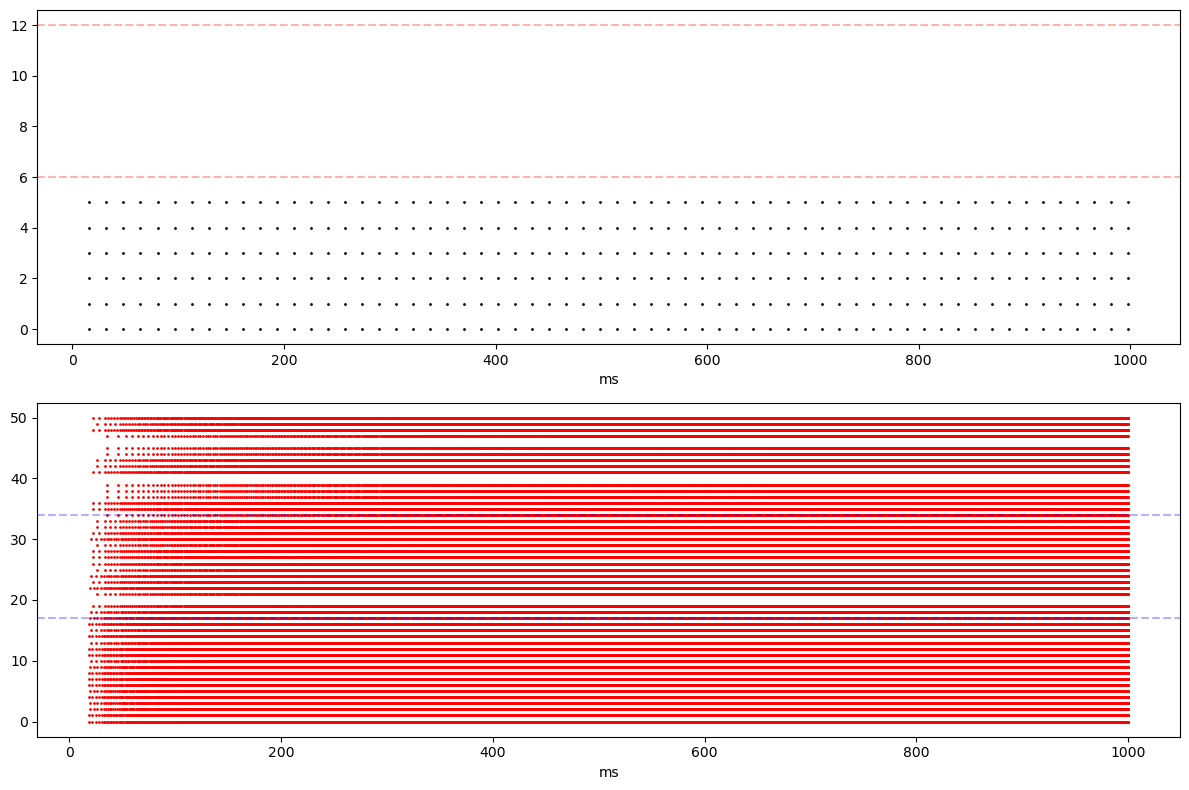

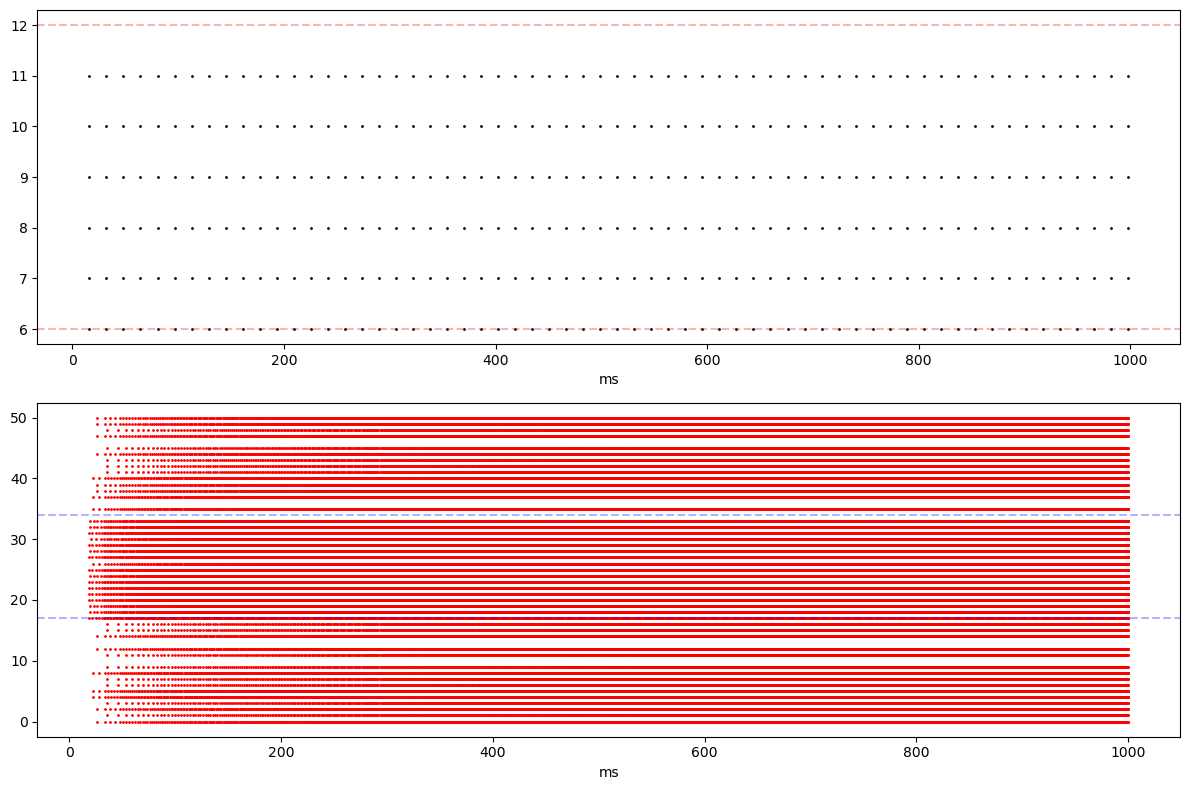

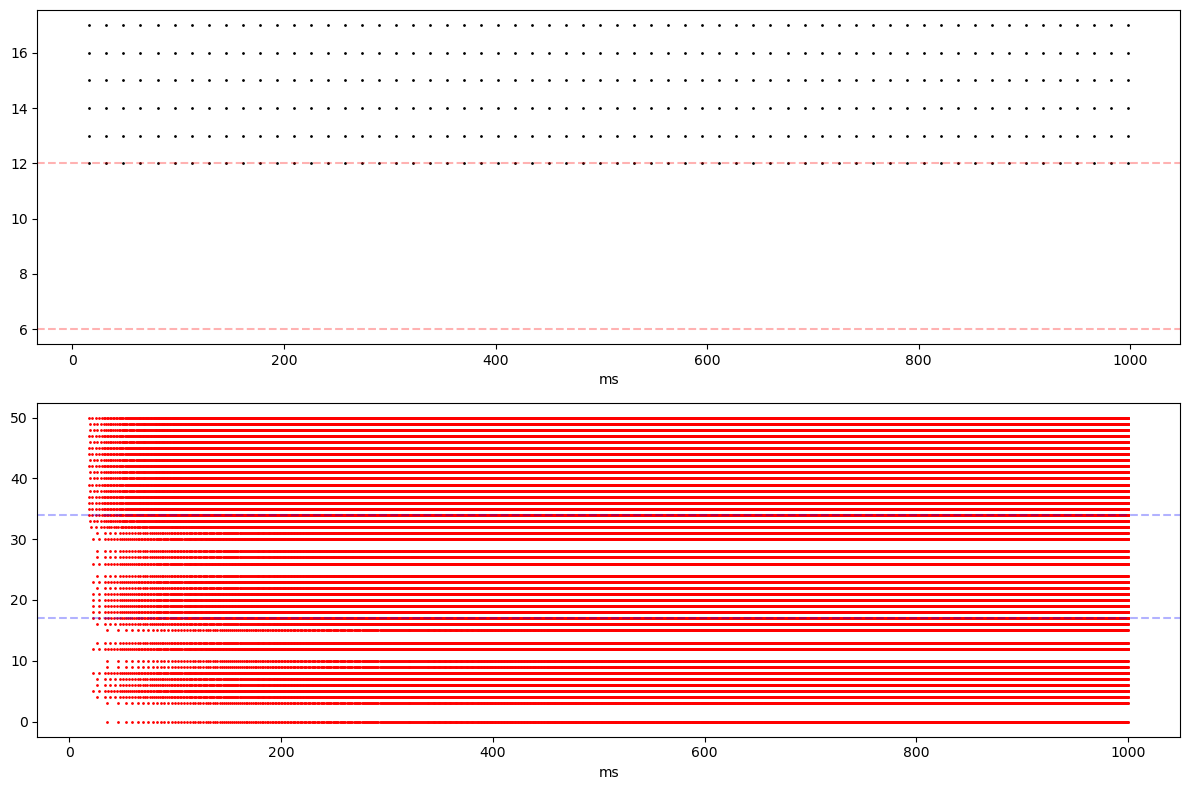

In [129]:
# 간단한 모델로 테스트 
def run_topographic_simulation(n_fsn=18, n_msn_d1=51, stim_region=0, simulation_time=1000*ms):

    scenario = connect_prob(n_fsn, n_msn_d1)

    fsn_params = '''
    dv/dt = (-v + I_ext + I_syn) / tau : 1
    I_ext : 1  
    I_syn : 1  
    tau : second
    '''
    
    msn_params = '''
    dv/dt = (-v + I_ext + I_syn) / tau : 1
    I_ext : 1
    I_syn : 1
    tau : second
    '''
    
    FSN = NeuronGroup(n_fsn, fsn_params,
                      threshold='v>0.8',
                      reset='v=0',
                      method='euler')
    
    MSN_D1 = NeuronGroup(n_msn_d1, msn_params,
                         threshold='v>0.8',
                         reset='v=0',
                         method='euler')
    FSN.v = 0
    FSN.tau = 10*ms
    FSN.I_ext = 0 

    region_size = n_fsn // 3
    stim_start = stim_region * region_size
    stim_end = (stim_region + 1) * region_size
    FSN.I_ext[stim_start:stim_end] = 1.0  
    
    MSN_D1.v = 0
    MSN_D1.tau = 20*ms
    MSN_D1.I_ext = 0
    
    fsn_msn_conn = scenario['connections']['FSN_MSN_D1']
    S = Synapses(FSN, MSN_D1,
                 'w : 1',
                 on_pre='I_syn_post += w')
    
    conn_matrix = fsn_msn_conn['connectivity']
    connected_pairs = np.where(conn_matrix)
    S.connect(i=connected_pairs[0], j=connected_pairs[1])
    S.w = 1
    
    FSN_spikes = SpikeMonitor(FSN)
    MSN_D1_spikes = SpikeMonitor(MSN_D1)
    
    net = Network(FSN, MSN_D1, S, FSN_spikes, MSN_D1_spikes)
    net.run(simulation_time)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # FSN
    ax1.plot(FSN_spikes.t/ms, FSN_spikes.i, '.k', markersize=2)
    ax1.axhline(y=region_size, color='r', linestyle='--', alpha=0.3)
    ax1.axhline(y=2*region_size, color='r', linestyle='--', alpha=0.3)
    ax1.set_xlabel('ms')
    
    # MSN D1
    msn_region_size = n_msn_d1 // 3
    ax2.plot(MSN_D1_spikes.t/ms, MSN_D1_spikes.i, '.r', markersize=2)
    ax2.axhline(y=msn_region_size, color='b', linestyle='--', alpha=0.3)
    ax2.axhline(y=2*msn_region_size, color='b', linestyle='--', alpha=0.3)
    ax2.set_xlabel('ms')
    
    plt.tight_layout()
    
    return {
        'FSN_spikes': FSN_spikes,
        'MSN_D1_spikes': MSN_D1_spikes,
        'figure': fig
    }

for region in range(3):
    results = run_topographic_simulation(stim_region=region)
    plt.show()

In [121]:
def run_topographic_simulation(n_fsn=18, n_msn_d1=51, stim_region=0, simulation_time=1000*ms):
    
    FSN_params = {
        'vr': -64.4*mV,
        'vt': -50*mV,
        'k': 1,
        'u': 0 * mV/ms,
        'th': 25 * mV,
        'a': 0.2 * 1/ms,
        'b': 0.025 * 1/ms,
        'C': 80 * pF
    }

    MSND1_params = {
        'vr': -78.2*mV,
        'vt': -29.7*mV,
        'k': 1,
        'u': 0 * mV/ms,
        'th': 40 * mV,
        'a': 0.01 * 1/ms,
        'b': -20 * 1/ms,
        'C': 15.2 * pF
    }

    neuron_eqs = '''
    dv / dt = (k*1*pF/ms/mV*(v-vr)*(v-vt) - u*pF + I_ext + I_syn) / C : volt (unless refractory)
    du/dt = a * (b * (v - vr) - u) : volt/second
    I_syn  : amp
    I_ext : amp
    a : 1/second
    b : 1/second
    k : 1
    vt     : volt
    vr     : volt 
    th     : volt
    C      : farad
    d       : volt/second
    '''

    scenario = connect_prob(n_fsn, n_msn_d1)

    FSN = NeuronGroup(n_fsn, neuron_eqs,
                      threshold='v >= th',
                      reset='v = vr; u += d',
                      method='euler')
    
    FSN.vr = FSN_params['vr']
    FSN.vt = FSN_params['vt']
    FSN.k = FSN_params['k']
    FSN.u = FSN_params['u']
    FSN.th = FSN_params['th']
    FSN.a = FSN_params['a']
    FSN.b = FSN_params['b']
    FSN.C = FSN_params['C']
    FSN.d = 0 * mV/second 
    
    
    # topographic input 
    region_size = n_fsn // 3
    stim_start = stim_region * region_size
    stim_end = (stim_region + 1) * region_size
    FSN.I_ext[stim_start:stim_end] = 600.0 * pA

    MSN_D1 = NeuronGroup(n_msn_d1, neuron_eqs,
                         threshold='v >= th',
                         reset='v = vr; u += d',
                         method='euler')

    MSN_D1.vr = MSND1_params['vr']
    MSN_D1.vt = MSND1_params['vt']
    MSN_D1.k = MSND1_params['k']
    MSN_D1.u = MSND1_params['u']
    MSN_D1.th = MSND1_params['th']
    MSN_D1.a = MSND1_params['a']
    MSN_D1.b = MSND1_params['b']
    MSN_D1.C = MSND1_params['C']
    MSN_D1.d = 66.9 * mV/second
    
    
    """
    syn = Synapses(FSN, MSN_D1, model='''
    I_GABA_post = w * g * (E_GABA - v_post) : amp (summed)
    dg/dt = -g/tau_GABA : siemens
    E_GABA = -80*mV : volt 
    tau_GABA = 5*ms : second 
    w : 1
    ''',
    on_pre='''
    g += w*nS 
    ''')
    """
    syn = Synapses(FSN, MSN_D1,
                'w : 1',
                on_pre='I_syn_post += w * pA')

    conn_matrix = scenario['connections']['FSN_MSN_D1']['connectivity']
    connected_pairs = np.where(conn_matrix)
    syn.connect(i=connected_pairs[0], j=connected_pairs[1])
    syn.w = 1  
    
    FSN_spikes = SpikeMonitor(FSN)
    MSN_D1_spikes = SpikeMonitor(MSN_D1)
    
    net = Network(FSN, MSN_D1, syn, FSN_spikes, MSN_D1_spikes)
    net.run(simulation_time)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(FSN_spikes.t/ms, FSN_spikes.i, '.k', markersize=2)
    ax1.axhline(y=region_size, color='r', linestyle='--', alpha=0.3)
    ax1.axhline(y=2*region_size, color='r', linestyle='--', alpha=0.3)
    ax1.set_xlabel('ms')
    ax1.set_ylabel('Neuron Index')
    
    msn_region_size = n_msn_d1 // 3
    ax2.plot(MSN_D1_spikes.t/ms, MSN_D1_spikes.i, '.r', markersize=2)
    ax2.axhline(y=msn_region_size, color='b', linestyle='--', alpha=0.3)
    ax2.axhline(y=2*msn_region_size, color='b', linestyle='--', alpha=0.3)
    ax2.set_xlabel('ms')
    ax2.set_ylabel('Neuron Index')
    
    plt.tight_layout()
    
    return {
        'FSN_spikes': FSN_spikes,
        'MSN_D1_spikes': MSN_D1_spikes,
        'figure': fig
    }

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


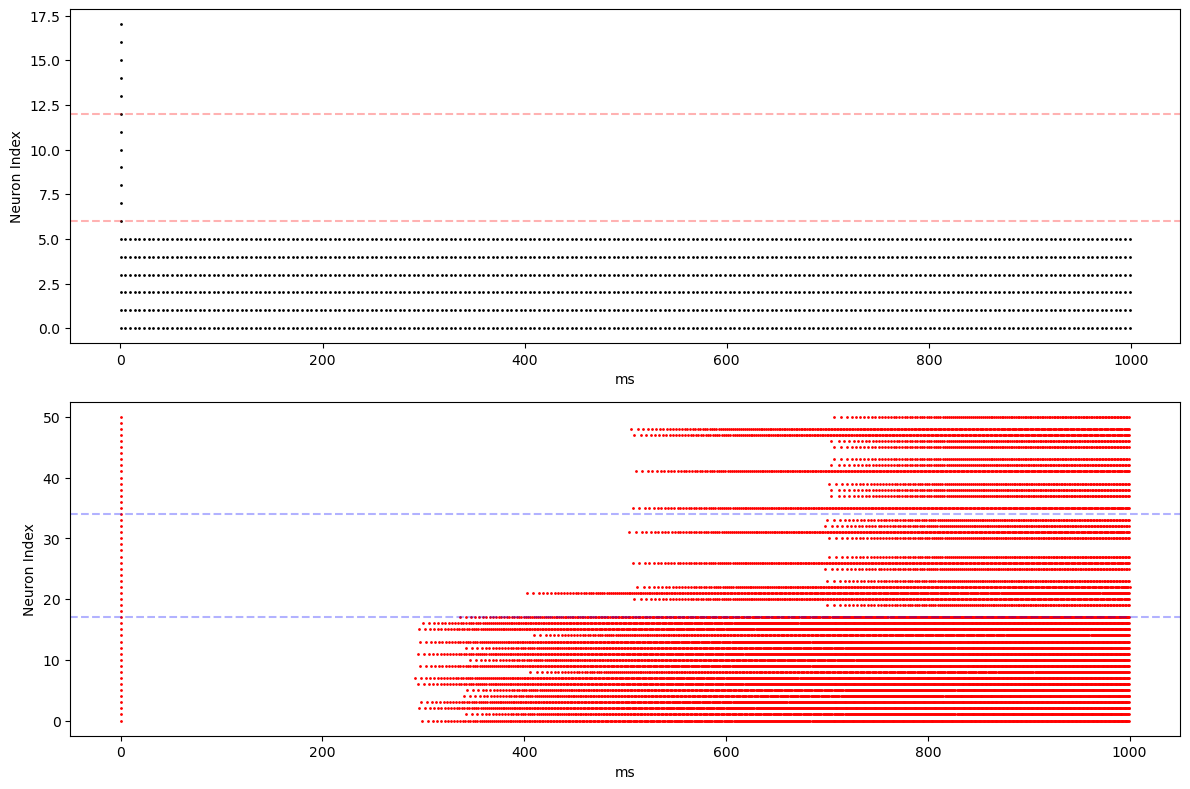

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


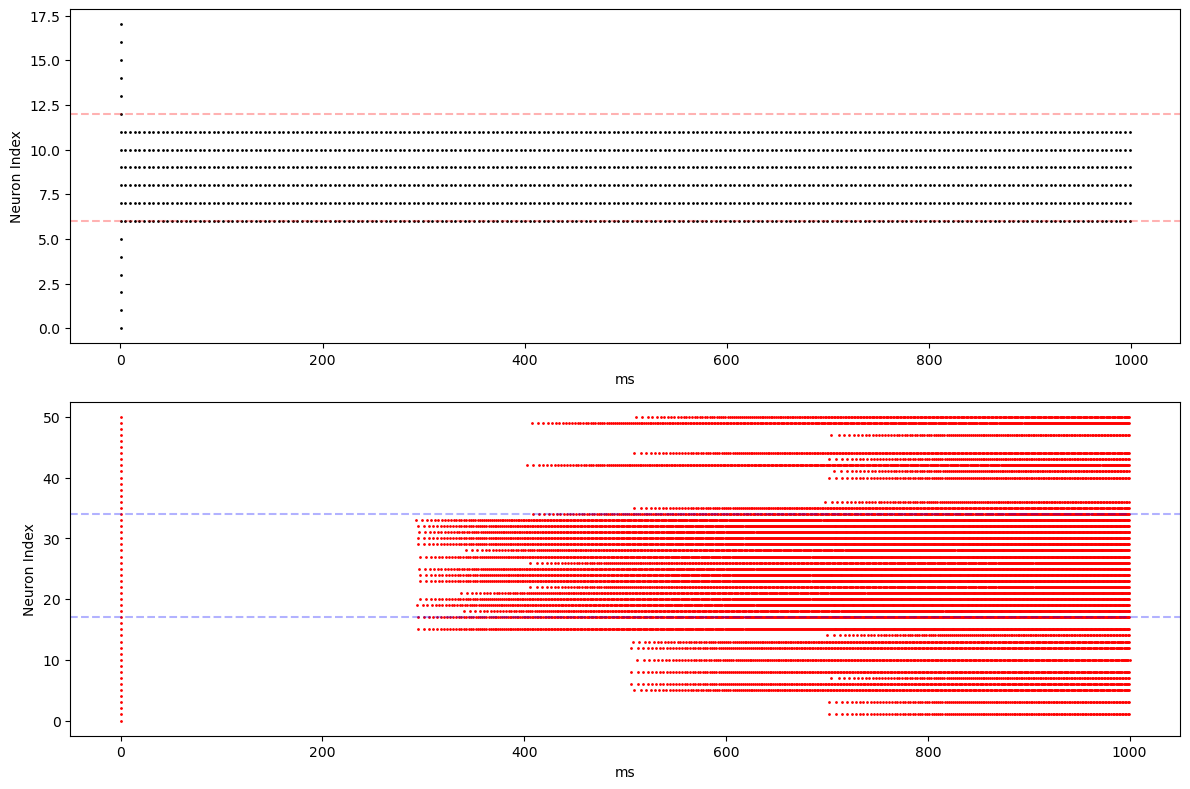

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


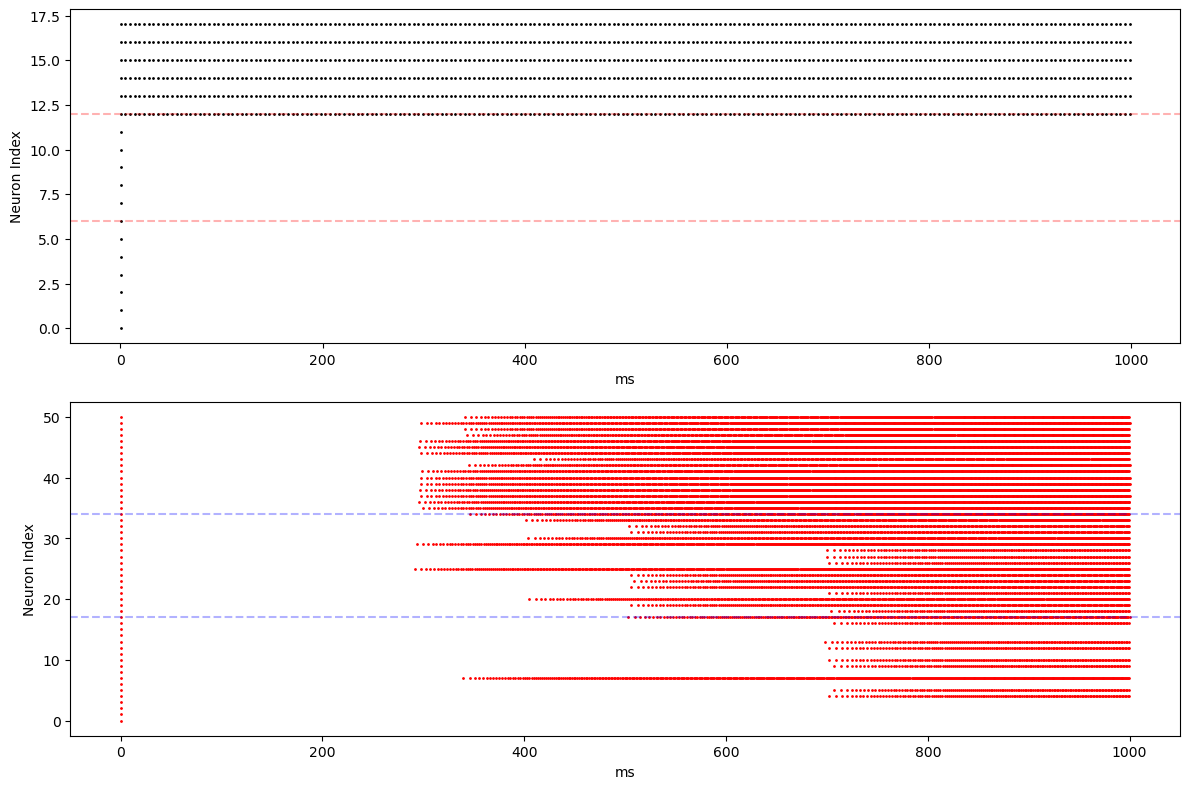

In [122]:
for region in range(3):
    results = run_topographic_simulation(stim_region=region)
    plt.show()

In [13]:
def run_topographic_simulation(n_fsn=18, n_msn_d1=51, stim_region=0, simulation_time=1000*ms):
    
    FSN_params = {
        'g_L': 16.67 * nS,
        'vr': -65*mV,
        'th': -54 * mV,
        'E_L': -65 * mV,
        'C': 80 * pF
    }

    MSND1_params = {
        'g_L': 8.04 * nS,
        'vr': -87.2*mV,
        'th': -45 * mV,
        'E_L': -87.2 * mV,
        'C': 192 * pF
    }

    # LIF Model 
    neuron_eqs = '''
    dv/dt = (-g_L*(v-E_L) + I_syn + I_ext)/C : volt
    g_L     : siemens
    E_L     : volt
    d       : volt/second
    vr      : volt
    th      : volt
    I_syn : amp
    I_ext : amp
    C : farad
    '''

    scenario = connect_prob(n_fsn, n_msn_d1)

    FSN = NeuronGroup(n_fsn, neuron_eqs,
                      threshold='v >= th',
                      reset='v = vr',
                      method='euler')
    
    FSN.g_L = FSN_params['g_L']
    FSN.vr = FSN_params['vr']
    FSN.th = FSN_params['th']
    FSN.E_L = FSN_params['E_L']
    FSN.C = FSN_params['C']
    FSN.v = 0 * mV
    FSN.I_ext = 0 

    region_size = n_fsn // 3
    stim_start = stim_region * region_size
    stim_end = (stim_region + 1) * region_size
    FSN.I_ext[stim_start:stim_end] = 800.0 * pA

    MSN_D1 = NeuronGroup(n_msn_d1, neuron_eqs,
                         threshold='v >= th',
                         reset='v = vr',
                         method='euler')
    
    MSN_D1.g_L = MSND1_params['g_L']
    MSN_D1.vr = MSND1_params['vr']
    MSN_D1.th = MSND1_params['th']
    MSN_D1.E_L = MSND1_params['E_L']
    MSN_D1.C = MSND1_params['C']
    MSN_D1.v = 0 * mV
    MSN_D1.I_ext = 0
    
    syn = Synapses(FSN, MSN_D1,
                'w : 1',
                on_pre='I_syn_post += w * pA')

    conn_matrix = scenario['connections']['FSN_MSN_D1']['connectivity']
    connected_pairs = np.where(conn_matrix)
    syn.connect(i=connected_pairs[0], j=connected_pairs[1])
    syn.w = 1  
    
    FSN_spikes = SpikeMonitor(FSN)
    MSN_D1_spikes = SpikeMonitor(MSN_D1)
    
    net = Network(FSN, MSN_D1, syn, FSN_spikes, MSN_D1_spikes)
    net.run(simulation_time)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(FSN_spikes.t/ms, FSN_spikes.i, '.k', markersize=2)
    ax1.axhline(y=region_size, color='r', linestyle='--', alpha=0.3)
    ax1.axhline(y=2*region_size, color='r', linestyle='--', alpha=0.3)
    ax1.set_xlabel('ms')
    ax1.set_ylabel('Neuron Index')
    
    msn_region_size = n_msn_d1 // 3
    ax2.plot(MSN_D1_spikes.t/ms, MSN_D1_spikes.i, '.r', markersize=2)
    ax2.axhline(y=msn_region_size, color='b', linestyle='--', alpha=0.3)
    ax2.axhline(y=2*msn_region_size, color='b', linestyle='--', alpha=0.3)
    ax2.set_xlabel('ms')
    ax2.set_ylabel('Neuron Index')
    
    plt.tight_layout()
    
    return {
        'FSN_spikes': FSN_spikes,
        'MSN_D1_spikes': MSN_D1_spikes,
        'figure': fig
    }

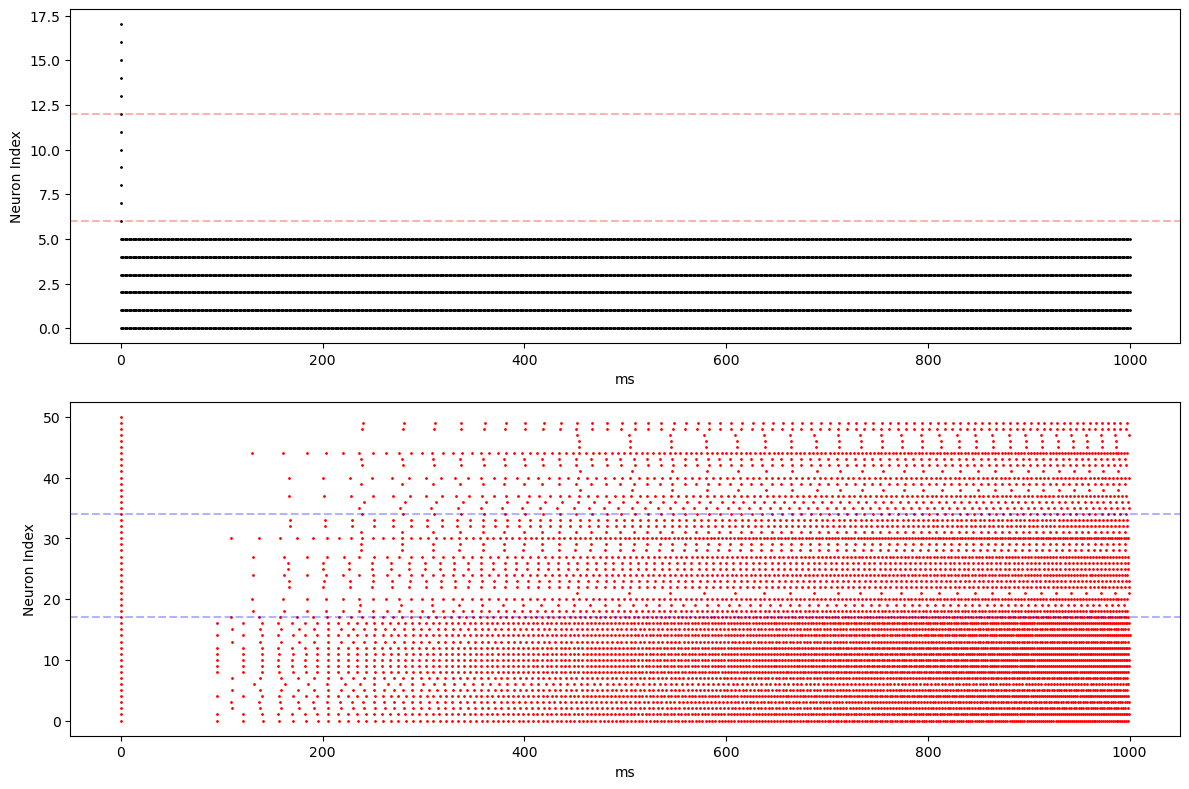

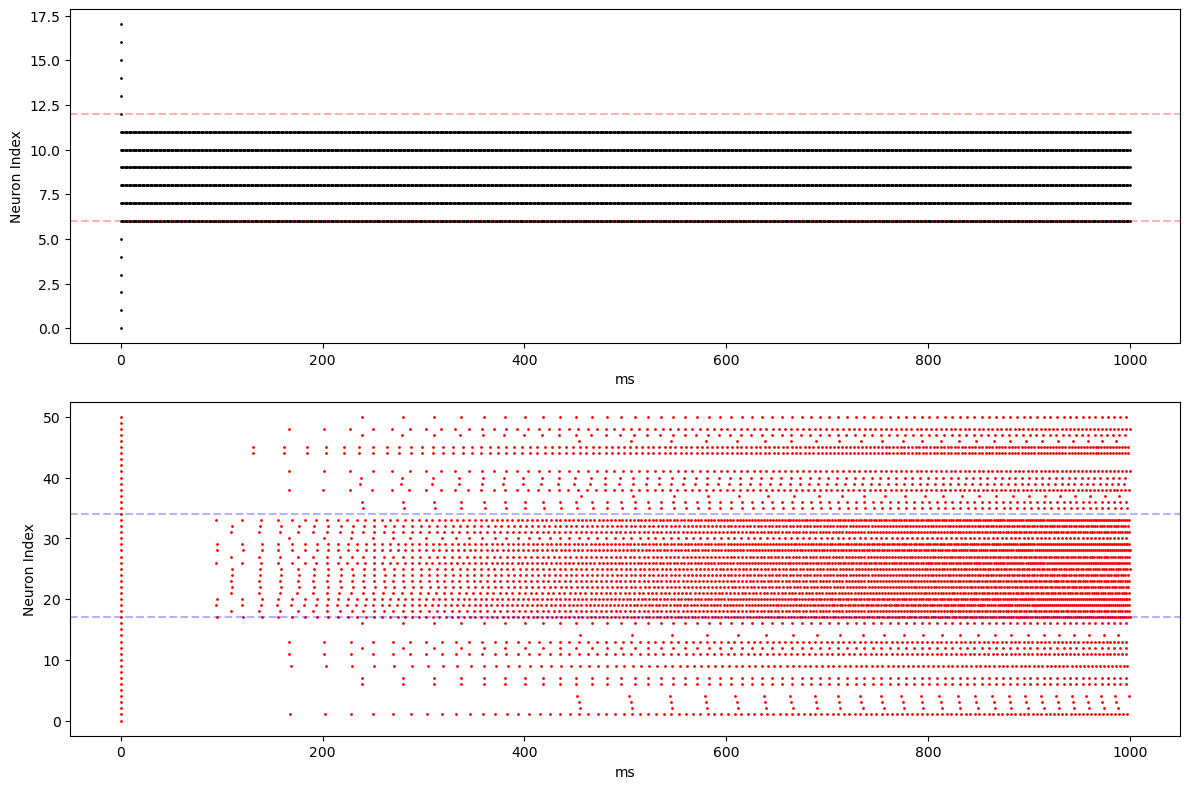

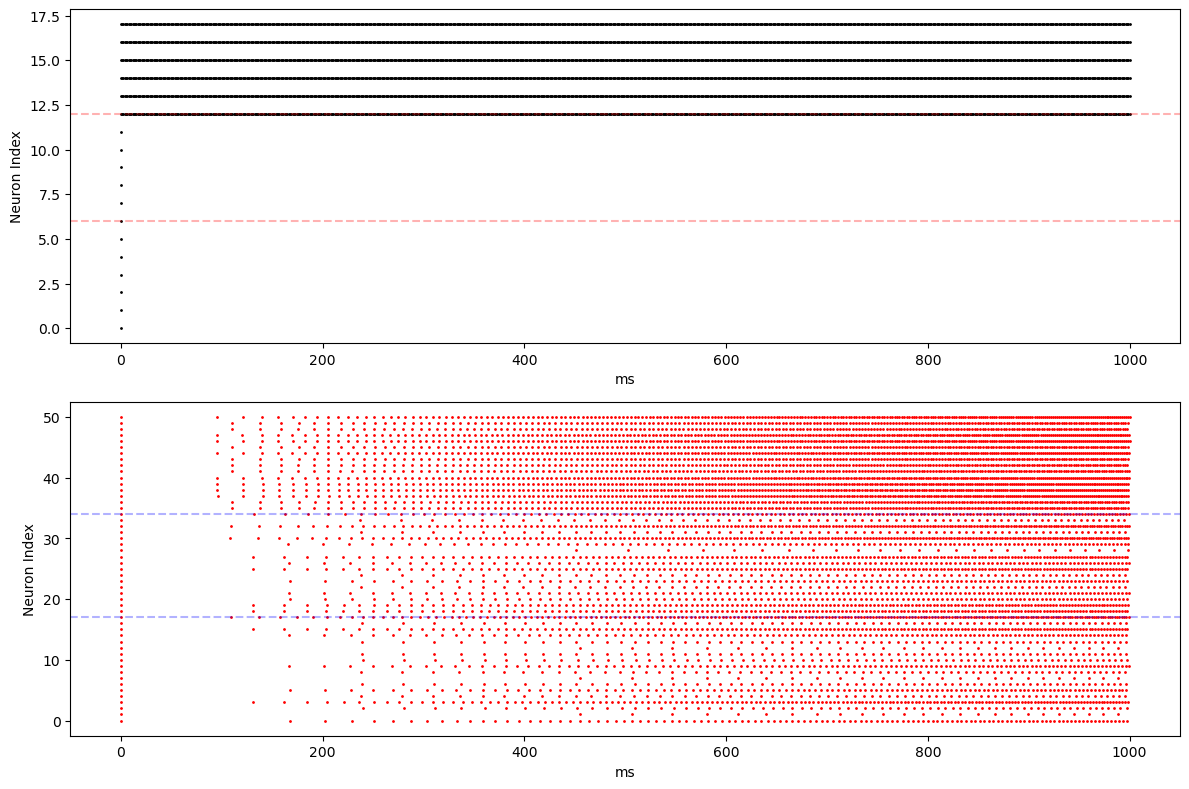

In [14]:
for region in range(3):
    results = run_topographic_simulation(stim_region=region)
    plt.show()

[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3, 0.3, 0.3, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3, 0.3, 0.3, 0.3, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3, 0.3, 0.3, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.9,

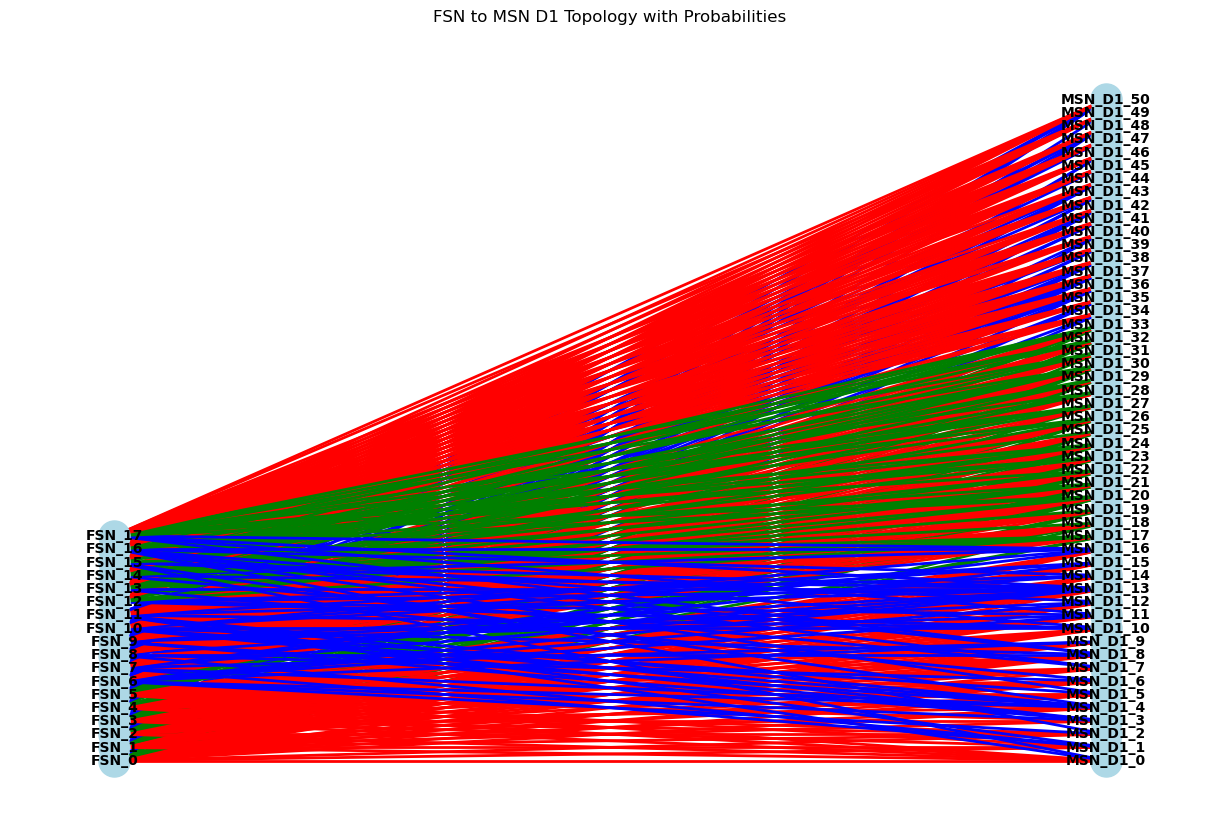

In [15]:
def visualize_topology_with_probabilities(scenario):

    G = nx.Graph()
    
    # FSN과 MSN D1 노드 추가
    n_fsn = scenario['populations']['FSN']
    n_msn_d1 = scenario['populations']['MSN_D1']
    
    fsn_nodes = [f'FSN_{i}' for i in range(n_fsn)]
    msn_d1_nodes = [f'MSN_D1_{i}' for i in range(n_msn_d1)]
    
    G.add_nodes_from(fsn_nodes, bipartite=0)
    G.add_nodes_from(msn_d1_nodes, bipartite=1)
    
    conn_matrix = scenario['connections']['FSN_MSN_D1']['connectivity']
    prob_matrix = scenario['connections']['FSN_MSN_D1']['probabilities']

    for fsn_idx in range(n_fsn):
        for msn_idx in range(n_msn_d1):
            if conn_matrix[fsn_idx, msn_idx] == 1:
                G.add_edge(f'FSN_{fsn_idx}', f'MSN_D1_{msn_idx}', weight=prob_matrix[fsn_idx, msn_idx])
    
    pos = {}
    pos.update((node, (1, i)) for i, node in enumerate(fsn_nodes))  
    pos.update((node, (2, i)) for i, node in enumerate(msn_d1_nodes))
    
    edges = G.edges(data=True)
    weights = [data['weight'] for _, _, data in edges]
    print(weights)

    color_map = {
        0.9: 'red',
        0.5: 'green',
        0.3: 'blue'
    }
    
    edge_colors = [color_map.get(weight, 'black') for weight in weights]  
    edge_widths = [2 for _ in weights] 
    
    # 그래프 시각화
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_weight='bold',
            edge_color=edge_colors, width=edge_widths)
    plt.title('FSN to MSN D1 Topology with Probabilities')
    plt.show()

scenario = connect_prob()
visualize_topology_with_probabilities(scenario)

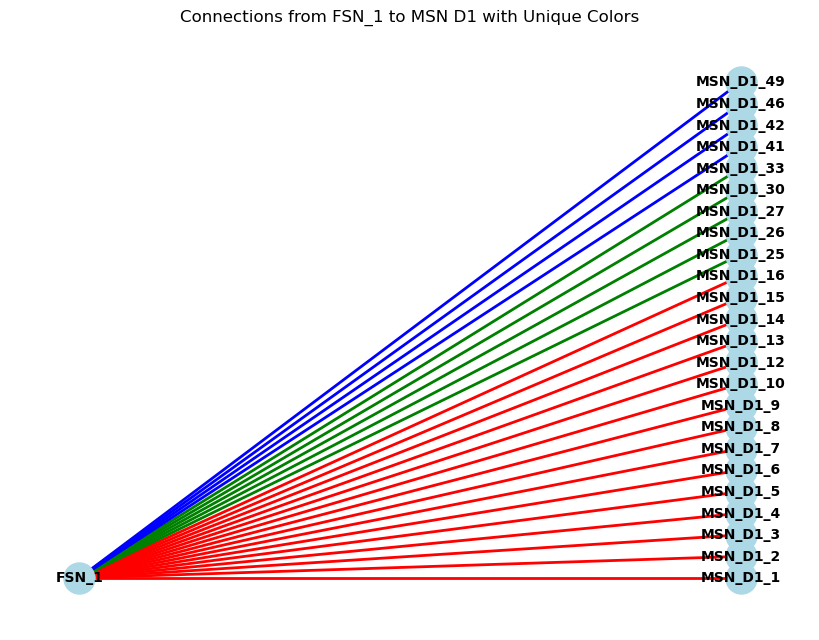

In [16]:
def visualize_single_fsn_topology_with_prob(scenario, fsn_index=0):

    G = nx.Graph()
    
    n_fsn = scenario['populations']['FSN']
    n_msn_d1 = scenario['populations']['MSN_D1']
    
    fsn_node = f'FSN_{fsn_index}'
    G.add_node(fsn_node, bipartite=0)
    
    conn_matrix = scenario['connections']['FSN_MSN_D1']['connectivity']
    prob_matrix = scenario['connections']['FSN_MSN_D1']['probabilities']

    msn_d1_nodes = []
    for msn_idx in range(n_msn_d1):
        if conn_matrix[fsn_index, msn_idx] == 1:
            msn_node = f'MSN_D1_{msn_idx}'
            G.add_node(msn_node, bipartite=1)
            G.add_edge(fsn_node, msn_node, weight=prob_matrix[fsn_index, msn_idx])
            msn_d1_nodes.append(msn_node)
    
    pos = {fsn_node: (1, 0)}
    pos.update((node, (2, i)) for i, node in enumerate(msn_d1_nodes)) 
    
    edges = G.edges(data=True)
    weights = [data['weight'] for _, _, data in edges]
    
    color_map = {
        0.9: 'red',
        0.5: 'green',
        0.3: 'blue'
    }
    
    edge_colors = [color_map.get(weight, 'black') for weight in weights]  
    edge_widths = [2 for _ in weights]  
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_weight='bold',
            edge_color=edge_colors, width=edge_widths)
    plt.title(f'Connections from FSN_{fsn_index} to MSN D1 with Unique Colors')
    plt.show()

scenario = connect_prob()
visualize_single_fsn_topology_with_prob(scenario, fsn_index=1)